<a href="https://colab.research.google.com/github/meesamamir/LLM-Project/blob/main/LLM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Multi-Classification using NLP Techniques

This project implements a comprehensive news classification system using NLP techniques. We will use the AG News dataset, which contains news headlines labeled as follows:

0: World

1: Sports

2: Business

3: Sci/Tech

The goal is to first build a baseline classifier using logistic regression and then develop a neural network classifier for comparison.

Below, we describe each step and provide detailed comments.

In [ ]:
!pip install datasets
!pip install gensim
!pip install seaborn

!pip install numpy==1.26.4

# https://stackoverflow.com/questions/78650222/valueerror-numpy-dtype-size-changed-may-indicate-binary-incompatibility-expec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 33.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found 

In [ ]:
import numpy as np
import pandas as pd

from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import random
np.random.seed(42)

# 1 - Data Prep

## 1.1 - Data Preprocessing
We load the AG News dataset using the Huggingface datasets library. Then, we preprocess the text headlines by converting to lowercase and using CountVectorizer to convert the text into bag-of-words features. We will later report the vocabulary size and the shape of our data matrices.

TODO: Find ways to fix any training imbalances in data labels

## 1.2 - Load the AG News dataset

In [ ]:
# The default split provides train and test

from datasets import load_dataset

dataset = load_dataset("fancyzhx/ag_news")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
from collections import Counter
from datasets import load_dataset

# Convert dataset to pandas DataFrame
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Count labels in training and test sets
train_counts = Counter(df_train['label'])
test_counts = Counter(df_test['label'])

# Print label distribution
print("Training Set Label Counts:", train_counts)
print("Testing Set Label Counts:", test_counts)

Training Set Label Counts: Counter({2: 30000, 3: 30000, 1: 30000, 0: 30000})
Testing Set Label Counts: Counter({2: 1900, 3: 1900, 1: 1900, 0: 1900})


## 1.3 - Extract training and test texts and labels

In [ ]:
# For convenience, extract training and test texts and labels

train_texts = [example["text"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]

test_texts = [example["text"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]

print(f"Number of training examples (full): {len(train_texts)}")
print(f"Number of test examples: {len(test_texts)}")

Number of training examples (full): 120000
Number of test examples: 7600


## 1.4 - Add slicing of training data

Comment out the following code block to use full 120k rows for training data

In [ ]:
import random
random.seed(42)

indices = list(range(len(train_texts)))
random.shuffle(indices)

slice_indices = indices[:30000]  # Select 30k rows (approx. 25%)

# slice_indices = indices[:120000]  # Select 120k rows

train_texts = [train_texts[i] for i in slice_indices]
train_labels = [train_labels[i] for i in slice_indices]

print(f"Using {len(train_texts)} training examples for experiments.")

Using 30000 training examples for experiments.


## 1.5 - Display a snapshot of the data (first 5 rows)

In [ ]:
snapshot = pd.DataFrame({"Headline": train_texts, "Label": train_labels}).head(5)
print("Data Snapshot (first 5 rows):")
print(snapshot)

Data Snapshot (first 5 rows):
                                            Headline  Label
0  Thirst, Fear and Bribes on Desert Escape from ...      0
1  Toshiba 20 TV freaks out, sends distress signa...      3
2  British hostage tried fleeing before death: re...      3
3  Keychain clicker kills TVs Discrete device tur...      3
4  Cleric returns to Iraq, orders march on Najaf ...      0


## 1.6 - Feature Extraction with Bag-of-Words / TF‑IDF
We use ***CountVectorizer*** from scikit-learn to tokenize the headlines. Text data is converted into numerical features using **CountVectorizer**

*   All words are converted to lowercase.
*   We use a minimum document frequency to filter rare tokens.

We then report the vocabulary size and the shapes of the training and test matrices.

In [ ]:
# Create a CountVectorizer with lowercase conversion and minimum document frequency threshold
vectorizer = CountVectorizer(lowercase=True, min_df=3)

# Fit on training texts and transform both training and test texts
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

# Report the vocabulary size and matrix shapes
vocab_size = len(vectorizer.vocabulary_)
print(f"\nVocabulary size: {vocab_size}\n")
print(f"Shape of training data matrix: {X_train.shape}") # (n_train, vocab_size)
print(f"Shape of test data matrix: {X_test.shape}")      # (n_test, vocab_size)



Vocabulary size: 18331

Shape of training data matrix: (30000, 18331)
Shape of test data matrix: (7600, 18331)


# 2 - Baseline Classifier: Logistic Regression

We implement a baseline logistic regression classifier.

*   First, we train without regularization.
*   Then, we train with L2 regularization.

We report the classification accuracies on the training and test sets.

## 2.1 - Logistic Regression **without** Regularization

In [ ]:
print("\n### Logistic Regression Baseline (No Regularization) ###\n")

# Instantiate logistic regression with a very high C to effectively turn off regularization
lr_no_reg = LogisticRegression(fit_intercept=True, C=1e9, solver="liblinear", max_iter=1000)

# Train the classifier
lr_no_reg.fit(X_train, train_labels)

# Predict on training and test sets
train_preds_no_reg = lr_no_reg.predict(X_train)
test_preds_no_reg = lr_no_reg.predict(X_test)

# Computing accuracy scores
train_acc_no_reg = accuracy_score(train_labels, train_preds_no_reg)
test_acc_no_reg = accuracy_score(test_labels, test_preds_no_reg)

print(f"Training Accuracy (No Reg): {train_acc_no_reg:.4f}")
print(f"Test Accuracy (No Reg): {test_acc_no_reg:.4f}")



### Logistic Regression Baseline (No Regularization) ###

Training Accuracy (No Reg): 0.9998
Test Accuracy (No Reg): 0.8683


## 2.2 - Logistic Regression with L2 Regularization

In [ ]:
print("\n### Logistic Regression Baseline (With L2 Regularization, lambda=10.0) ###\n")

# For L2 regularization with lambda=10.0, set C = 1/lambda = 0.1.
lr_reg = LogisticRegression(fit_intercept=True, C=0.1, solver="liblinear", max_iter=1000)

# Train the classifier
lr_reg.fit(X_train, train_labels)

# Predict on training and test sets
train_preds_reg = lr_reg.predict(X_train)
test_preds_reg = lr_reg.predict(X_test)

# Computing accuracy scores
train_acc_reg = accuracy_score(train_labels, train_preds_reg)
test_acc_reg = accuracy_score(test_labels, test_preds_reg)

print(f"Training Accuracy (With Reg): {train_acc_reg:.4f}")
print(f"Test Accuracy (With Reg): {test_acc_reg:.4f}")


### Logistic Regression Baseline (With L2 Regularization, lambda=10.0) ###

Training Accuracy (With Reg): 0.9463
Test Accuracy (With Reg): 0.8992


## 2.3 - Additional Evaluation (Precision, Recall, F1-score, Confusion Matrix)


In [ ]:
print("\nClassification Report (Test, With Regularization):")
print(classification_report(test_labels, test_preds_reg))

print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds_reg))



Classification Report (Test, With Regularization):
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      1900
           1       0.94      0.97      0.96      1900
           2       0.87      0.85      0.86      1900
           3       0.87      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600

Confusion Matrix:
[[1695   66   83   56]
 [  22 1843   18   17]
 [  69   20 1623  188]
 [  61   26  140 1673]]


## 2.4 - Confusion Matrix Heatmap

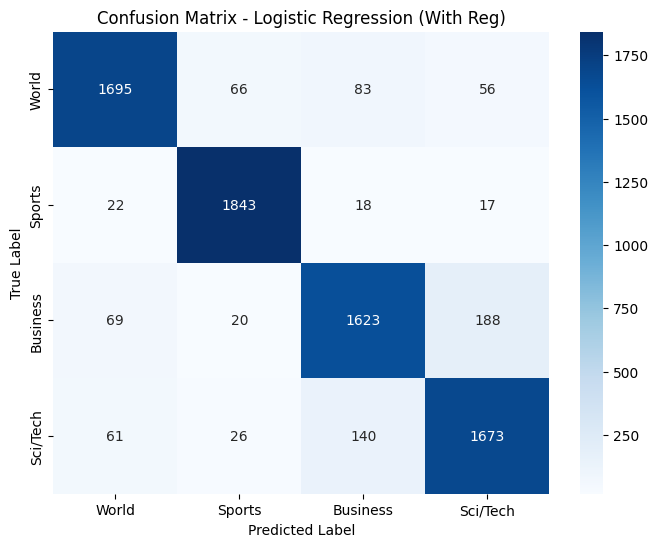

In [ ]:
import seaborn as sns

label_names = ["World", "Sports", "Business", "Sci/Tech"]
cm = confusion_matrix(test_labels, test_preds_reg)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix - Logistic Regression (With Reg)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 3 - Neural Network Classifier

Next, we implement a simple feedforward neural network classifier for the news classification task. The architecture is as follows:

1. Embedding Layer: Converts word indices to dense vectors.

2. First Hidden Layer: Sums the embeddings over the sequence and applies a linear transformation followed by a sigmoid activation.

3. Second Hidden Layer: Applies another linear transformation and sigmoid activation.

4. Output Layer: Applies a final linear transformation to predict the logits for the 4 classes, followed by softmax during evaluation.

We use PyTorch to implement the model.

Next, we will then train the network and evaluate its performance.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Setting torch seed for reproducibility
torch.manual_seed(42)


## 3.1 - Custom Dataset and DataLoader
We define a custom dataset to process news headlines. Each headline is tokenized (using a basic split), mapped to indices using the vocabulary from CountVectorizer, and then finally padded/truncated to a fixed length.

In [ ]:
# Building a word-to-index mapping from CountVectorizer's vocabulary
# Note: CountVectorizer vocabulary maps: word -> index.

vocab = vectorizer.vocabulary_

# We assume the padding index is 0. If "<pad>" is not in the vocabulary, we can use 0 as default.
# (In practice, you might add a dedicated pad token to the vocabulary.)
pad_idx = 0
default_idx = 0 # Unknown words get index 0

# Define maximum sequence length (e.g., 20 tokens)
max_seq_len = 20

# Convert text to lowercase and split on whitespace.
def tokenize_text(text):
  tokens = text.lower().split()
  indices = [vocab.get(token, default_idx) for token in tokens]

  return indices


In [ ]:
class AGNewsDataset(Dataset):
  def __init__(self, texts, labels, max_len=max_seq_len):
    self.texts = texts
    self.labels = labels
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    indices = tokenize_text(self.texts[idx])
    if len(indices) < self.max_len:
        indices = indices + [pad_idx] * (self.max_len - len(indices))
    else:
        indices = indices[:self.max_len]
    label = self.labels[idx]

    return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [ ]:
# Create dataset and DataLoader instances
train_dataset = AGNewsDataset(train_texts, train_labels, max_len=max_seq_len)
test_dataset = AGNewsDataset(test_texts, test_labels, max_len=max_seq_len)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## 3.2 - Neural Classifiers

In [ ]:
class NeuralClassifier(nn.Module):
  # Initialize the neural network.
  def __init__(self, vocab_size, embed_size, hidden_size, num_classes=4):

    super(NeuralClassifier, self).__init__()

    """ Initialize the neural network.
    Args:
        vocab_size (int): Size of the vocabulary.
        embed_size (int): Dimensionality of word embeddings.
        hidden_size (int): Size of hidden layers.
        num_classes (int): Number of news categories.
    """
    # Defined layers as per 'Neural Networks for NLP.pdf' slides 27-29:
        # Step 1: Embedding layer (with padding support)
        # Step 2: Linear layer from embed_size to hidden_size (first hidden layer)
        # Step 3: Second linear layer from hidden_size to hidden_size (second hidden layer)
        # Step 4: Output linear layer from hidden_size to class_size

    # Embedding layer (with padding support)
    self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)

    # 2 layers network
    self.fc1 = nn.Linear(embed_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)

    self.fc_out = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    """
    Forward pass of the model.

    Args:
        x (Tensor): Input tensor of shape [batch_size, seq_len].

    Returns:
        logits (Tensor): Logits of shape [batch_size, num_classes].
    """

    # Embedding lookup
    embedded = self.embedding(x)               # [B, L, E]

    # Sum over sequence length to create fixed-size representation
    summed = embedded.sum(dim=1)               # [B, E] fixed-size representation

    # Pass through layers with sigmoid activation
    h1 = torch.sigmoid(self.fc1(summed))       # first hidden layer
    h2 = torch.sigmoid(self.fc2(h1))           # second hidden layer

    logits = self.fc_out(h2)                   # output layer (logits)
    return logits


### 3.2.1 Deep Neural Classifier
Adding more layers can potentially improve accuracy by allowing the network to learn more complex, abstract representations. However, deeper networks also come with increased risk of overfitting and may require careful tuning (e.g., proper regularization, dropout, and learning rate adjustments). It's worth experimenting with a deeper architecture

Things we changed for this deep model:
- We replaced **torch.sigmoid** with **F.relu**, which is less prone to saturation and allows better gradient propagation

In training:
- The dropout rate is reduced to 0.2 to retain more information while still providing regularization
- Lowering the learning rate to 0.01 can help the deeper network converge more steadily

In [ ]:
class DeepNeuralClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes=4, dropout_rate=0.5):

        super(DeepNeuralClassifier, self).__init__()
        """
        Initialize the deep neural network.

        Args:
            vocab_size (int): Size of the vocabulary.
            embed_size (int): Dimensionality of word embeddings.
            hidden_size (int): Size of hidden layers.
            num_classes (int): Number of news categories.
            dropout_rate (float): Dropout probability.
        """

        # Embedding layer (with padding support)
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)

        # 4 layers network
        self.fc1 = nn.Linear(embed_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)

        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len].

        Returns:
            logits (Tensor): Logits of shape [batch_size, num_classes].
        """
        # Get embeddings: [batch_size, seq_len, embed_size]
        embedded = self.embedding(x)

        # Mean pooling across sequence length: [batch_size, embed_size]
        pooled = embedded.mean(dim=1)

        # Pass through layers with ReLU and dropout
        h1 = F.relu(self.fc1(pooled))
        h1 = self.dropout(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.dropout(h2)
        h3 = F.relu(self.fc3(h2))
        h3 = self.dropout(h3)
        logits = self.fc_out(h3)

        return logits

# # Example usage: instantiate the new deep model
# deep_model = DeepNeuralClassifier(vocab_size=len(vocab), embed_size=64, hidden_size=64, num_classes=4, dropout_rate=0.5)

# # Then use the same training and evaluation pipeline as before.


## 3.3 - Training and Evaluation Functions
We define functions for training one mini-batch and evaluating the model over an entire DataLoader.

### 3.3.1 - Training Function:


In [ ]:
def train_batch(batch, model, optimizer):
  """ Train on one mini-batch
  Args:
    batch (tuple): (texts, labels) from DataLoader.
    model (nn.Module): Neural network.
    optimizer: Optimizer instance.

  Returns:
      loss (float): Mini-batch loss.
  """
  # set in training mode
  model.train()

  # initialize optimizer
  optimizer.zero_grad()

  # forward: prediction
  texts, labels = batch
  logits = model(texts)
  loss = F.cross_entropy(logits, labels)

  # backward: gradient computation
  loss.backward()

  # norm clipping, in case the gradient norm is too large
  torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

  # gradient-based update parameter
  optimizer.step()

  return loss.item()

### 3.3.2 - Evaluating Function:

In [ ]:
def evaluate(loader, model):
  """ Evaluate model on given DataLoader.
  Args:
    loader (DataLoader): Evaluation data.
    model (nn.Module): Neural network.

  Returns:
    avg_loss (float): Average loss.
    accuracy (float): Classification accuracy.
  """
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total_examples = 0
  with torch.no_grad():
      for texts, labels in loader:
          logits = model(texts)
          loss = F.cross_entropy(logits, labels)
          total_loss += loss.item() * texts.size(0)
          preds = torch.argmax(logits, dim=1)
          total_correct += (preds == labels).sum().item()
          total_examples += texts.size(0)
  avg_loss = total_loss / total_examples
  accuracy = total_correct / total_examples

  return avg_loss, accuracy


## 3.4 - Training the Neural Network Classifier
Hyperparameters:

- Embedding size: 64

- Hidden size: 64

- Optimizer: SGD with learning rate 0.05

- Epochs: 50 (for demonstration; increase as needed)

We record the training loss and validation performance at each epoch.

In [ ]:
# Hyperparameters
embed_size = 64
hidden_size = 64
num_classes = 4
num_epochs = 50 # Increase for final training
learning_rate = 0.05

# Initialize the neural network model
model_nn = NeuralClassifier(
    vocab_size=len(vocab),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_classes=num_classes)

# Use SGD optimizer
optimizer_nn = torch.optim.SGD(
    model_nn.parameters(), lr=learning_rate)

# Record training progress
train_losses = []
val_losses = []
val_accuracies = []

print("\n### Training Neural Network Classifier ###\n")
for epoch in range(1, num_epochs + 1):
    # 1. Train for one epoch
    epoch_loss = 0.0
    for batch in train_loader:
        loss = train_batch(batch, model_nn, optimizer_nn)
        epoch_loss += loss

    # 2. Compute average training loss for this epoch
    avg_train_loss_nn = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss_nn)

    # 3. Evaluate on the test/validation set
    val_loss_nn, val_acc_nn = evaluate(test_loader, model_nn)
    val_losses.append(val_loss_nn)
    val_accuracies.append(val_acc_nn)

    # 4. Print a single summary line for this epoch
    print(f"Epoch {epoch}: "
          f"Train Loss = {avg_train_loss_nn:.4f}, "
          f"Val Loss = {val_loss_nn:.4f}, "
          f"Val Accuracy = {val_acc_nn:.4f}")

best_nn_acc = max(val_accuracies)
final_nn_acc = val_accuracies[-1]

print("\nNeural Network Training Completed.")
print(f"Best Validation Accuracy: {best_nn_acc:.4f}")
print(f"Final Validation Accuracy: {final_nn_acc:.4f}")


### Training Neural Network Classifier ###

Epoch 1: Train Loss = 1.3821, Val Loss = 1.3731, Val Accuracy = 0.3138
Epoch 2: Train Loss = 1.3537, Val Loss = 1.3355, Val Accuracy = 0.3559
Epoch 3: Train Loss = 1.3085, Val Loss = 1.2957, Val Accuracy = 0.4022
Epoch 4: Train Loss = 1.2676, Val Loss = 1.2649, Val Accuracy = 0.4279
Epoch 5: Train Loss = 1.2372, Val Loss = 1.2445, Val Accuracy = 0.4420
Epoch 6: Train Loss = 1.2201, Val Loss = 1.2396, Val Accuracy = 0.4511
Epoch 7: Train Loss = 1.2083, Val Loss = 1.2293, Val Accuracy = 0.4537
Epoch 8: Train Loss = 1.1982, Val Loss = 1.2248, Val Accuracy = 0.4657
Epoch 9: Train Loss = 1.1883, Val Loss = 1.2127, Val Accuracy = 0.4703
Epoch 10: Train Loss = 1.1779, Val Loss = 1.2050, Val Accuracy = 0.4786
Epoch 11: Train Loss = 1.1673, Val Loss = 1.2001, Val Accuracy = 0.4801
Epoch 12: Train Loss = 1.1562, Val Loss = 1.1888, Val Accuracy = 0.4871
Epoch 13: Train Loss = 1.1451, Val Loss = 1.1821, Val Accuracy = 0.4882
Epoch 14: Train Loss = 1.134

### 3.4.1 Training the Deep Neural Network

In [ ]:
# Hyperparameters for the deep model
deep_embed_size = 64
deep_hidden_size = 64
num_epochs_deep = 50      # Use the same number of epochs for comparison; adjust as needed
learning_rate_deep = 0.01 # Lower the learning rate for deep nn
dropout_rate = 0.2

# Instantiate the deep neural network model
deep_model = DeepNeuralClassifier(
    vocab_size=len(vocab),
    embed_size=deep_embed_size,
    hidden_size=deep_hidden_size,
    num_classes=num_classes,
    dropout_rate=dropout_rate)

# Use SGD optimizer for deep model
optimizer_deep = torch.optim.SGD(deep_model.parameters(), lr=learning_rate_deep)

# Record training progress for deep model
deep_train_losses = []
deep_val_losses = []
deep_val_accuracies = []

print("\n### Training Deep Neural Network Classifier ###\n")
for epoch in range(1, num_epochs_deep + 1):

    # 1. Train for one epoch
    epoch_loss = 0.0
    for batch in train_loader:
        loss = train_batch(batch, deep_model, optimizer_deep)
        epoch_loss += loss

    # 2. Compute average training loss for this epoch
    avg_train_loss = epoch_loss / len(train_loader)
    deep_train_losses.append(avg_train_loss)

    # 3. Evaluate on the test/validation set
    val_loss, val_acc = evaluate(test_loader, deep_model)
    deep_val_losses.append(val_loss)
    deep_val_accuracies.append(val_acc)

    # 4. Print a single summary line for this epoch
    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}")

best_deep_acc = max(deep_val_accuracies)
final_deep_acc = deep_val_accuracies[-1]

print("\nDeep Neural Network Training Completed.")
print(f"Best Validation Accuracy (Deep): {best_deep_acc:.4f}")
print(f"Final Validation Accuracy (Deep): {final_deep_acc:.4f}")



### Training Deep Neural Network Classifier ###

Epoch 1: Train Loss = 1.3867, Val Loss = 1.3862, Val Accuracy = 0.2520
Epoch 2: Train Loss = 1.3862, Val Loss = 1.3861, Val Accuracy = 0.2501
Epoch 3: Train Loss = 1.3861, Val Loss = 1.3860, Val Accuracy = 0.2509
Epoch 4: Train Loss = 1.3859, Val Loss = 1.3859, Val Accuracy = 0.2524
Epoch 5: Train Loss = 1.3857, Val Loss = 1.3857, Val Accuracy = 0.2521
Epoch 6: Train Loss = 1.3857, Val Loss = 1.3855, Val Accuracy = 0.2713
Epoch 7: Train Loss = 1.3853, Val Loss = 1.3853, Val Accuracy = 0.2704
Epoch 8: Train Loss = 1.3851, Val Loss = 1.3851, Val Accuracy = 0.2745
Epoch 9: Train Loss = 1.3850, Val Loss = 1.3848, Val Accuracy = 0.2767
Epoch 10: Train Loss = 1.3845, Val Loss = 1.3845, Val Accuracy = 0.2629
Epoch 11: Train Loss = 1.3843, Val Loss = 1.3841, Val Accuracy = 0.2791
Epoch 12: Train Loss = 1.3839, Val Loss = 1.3836, Val Accuracy = 0.2951
Epoch 13: Train Loss = 1.3833, Val Loss = 1.3829, Val Accuracy = 0.3066
Epoch 14: Train Loss = 

In [ ]:
import pandas as pd

comparison_data = {
    "Model": ["Original NN", "Deep NN"],
    "Best Val Accuracy": [best_nn_acc, best_deep_acc],
    "Final Val Accuracy": [final_nn_acc, final_deep_acc]
}
comparison_df = pd.DataFrame(comparison_data)
print("Comparison of Neural Network Models:")
print(comparison_df)

Comparison of Neural Network Models:
         Model  Best Val Accuracy  Final Val Accuracy
0  Original NN           0.564342            0.563421
1      Deep NN           0.459211            0.459211


## 3.5 - Visualization and Summary
We plot the training and validation loss curves. In addition, note that evaluation metrics such as precision, recall, and F1-score (as well as a confusion matrix) should be computed for a thorough evaluation. For language model-based approaches, perplexity would also be computed.


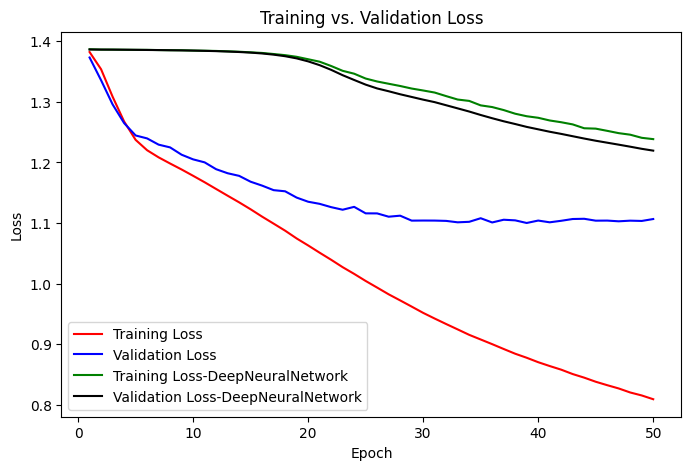

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, color="red", label="Training Loss")
plt.plot(range(1, num_epochs+1), val_losses, color="blue", label="Validation Loss")

plt.plot(range(1, num_epochs+1), deep_train_losses, color="green", label="Training Loss-DeepNeuralNetwork")
plt.plot(range(1, num_epochs+1), deep_val_losses, color="black", label="Validation Loss-DeepNeuralNetwork")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# 4 - Additional Experiments and Quantitative Analysis
This section performs further analysis on the dataset:
1. Plotting the frequency distribution of words (to check Zipf’s law).
2. Generating word embeddings using Word2Vec and displaying similar words.
3. Summarizing performance metrics in a table.

## 4.1 - Frequency Distribution Plot

In [ ]:
# Flatten all tokens from training texts (using simple whitespace split)
all_tokens = []
for text in train_texts:
    all_tokens.extend(text.lower().split())

token_counts = Counter(all_tokens)

# Sort tokens by frequency
sorted_counts = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
tokens, frequencies = zip(*sorted_counts)

# Plot rank-frequency (log-log scale)
ranks = range(1, len(frequencies) + 1)

plt.figure(figsize=(8, 5))
plt.loglog(ranks, frequencies, marker=".")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Zipf's Law)")
plt.show()

Frequency INVERSLY PROPORTIONAL to Rank

Hence, model follows Zipf's Law

##4.2 Word Embeddings using Word2Vec

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec

# Tokenize the training texts (simple whitespace split)
tokenized_texts = [text.lower().split() for text in train_texts]

# Train Word2Vec model (using a small dimension for demonstration)
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=50, window=5, min_count=3, workers=4, seed=42)

# Display top 5 similar words for selected keywords
keywords = ["economy", "games", "technology", "market"]
for word in keywords:
    if word in w2v_model.wv:
        similar = w2v_model.wv.most_similar(word, topn=5)
        print(f"\nTop similar words to '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.4f}")
    else:
        print(f"\n'{word}' not found in vocabulary.")


## 4.3 Performance Comparison Table

In [ ]:
# Create a summary table for performance metrics
import pandas as pd

# We have baseline (lr_reg) and neural network (model_nn) performance metrics.
# Here we use the test accuracy from earlier experiments.
performance_data = {
    "Model": ["Logistic Regression (With Reg)", "Neural Network"],
    "Test Accuracy": [test_acc_reg, val_accuracies[-1]]
}

performance_df = pd.DataFrame(performance_data)
print("Performance Comparison:")
print(performance_df)

# 5 - Error Analysis
Below, we discuss examples where the models fail. For instance, consider headlines that are misclassified by the baseline model.


In [ ]:
# For demonstration, print 5 misclassified examples from logistic regression with regularization
misclassified = []
for text, true_label, pred_label in zip(test_texts, test_labels, test_preds_reg):
    if true_label != pred_label:
        misclassified.append((text, true_label, pred_label))
    if len(misclassified) >= 5:
        break

print("Examples of Misclassified Headlines (Logistic Regression with Reg):")
for idx, (text, true_label, pred_label) in enumerate(misclassified, start=1):
    print(f"\nExample {idx}:")
    print(f"Headline: {text}")
    print(f"True Label: {true_label} ({label_names[true_label]})")
    print(f"Predicted Label: {pred_label} ({label_names[pred_label]})")

# Add more models here

Compare our models with models that are already in the market e.g. XGBOOST, RandomForest

Find standard/best methods to report results

In [ ]:
# Define label mapping
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Input: Manually enter a headline
headline = "Local sports team wins championship in a stunning upset"
print(f"Headline: {headline}\n")


# -------------------------------------------------------------------------------------------------------

# ---- Baseline Prediction using Logistic Regression ----
# Vectorize the headline using the previously fitted CountVectorizer
X_input = vectorizer.transform([headline])

# Get probability estimates
probs_baseline = lr_reg.predict_proba(X_input)[0]

# Determine the predicted label and confidence
pred_label_baseline = lr_reg.predict(X_input)[0]
confidence_baseline = np.max(probs_baseline) * 100

print("Baseline Logistic Regression:")
print(f" Predicted Label: {pred_label_baseline}: {label_mapping[pred_label_baseline]}")
print(f" Confidence: {confidence_baseline:.2f}%")
print()

# -------------------------------------------------------------------------------------------------------

# ---- Neural Network Prediction ----
# Tokenize the headline using our custom function
indices = tokenize_text(headline)
# Pad or truncate the sequence to max_seq_len
if len(indices) < max_seq_len:
    indices = indices + [pad_idx] * (max_seq_len - len(indices))
else:
    indices = indices[:max_seq_len]
# Convert to a torch tensor and add batch dimension
input_tensor = torch.tensor([indices], dtype=torch.long)

# Predict with the neural network
model_nn.eval()
with torch.no_grad():
    logits = model_nn(input_tensor)
    # Apply softmax to obtain probability distribution
    probs_nn = F.softmax(logits, dim=1)[0]
    pred_label_nn = torch.argmax(probs_nn).item()
    confidence_nn = probs_nn[pred_label_nn].item() * 100

print("Neural Network Classifier:")
print(f" Predicted Label: {pred_label_nn}: {label_mapping[pred_label_nn]}")
print(f" Confidence: {confidence_nn:.2f}%")


# 8 - LSTM Approach 2


## 8.1 - Data Preprocessing

Here we load the required libraries we will be using for the LSTM model implementation, and pre process the data

In [42]:
!pip install tensorflow
!pip install torch
!pip install torchtext

!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.9 MB/s eta 0:00:00


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import random

from collections import Counter
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [44]:
# Load the AG News dataset from Hugging Face
dataset = load_dataset("fancyzhx/ag_news")

# Convert the train and test datasets to pandas DataFrames
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

# Print basic dataset info
print("Training Set Label Distribution:", df_train['label'].value_counts())
print("Testing Set Label Distribution:", df_test['label'].value_counts())

# Extract texts and labels (we are using the full set here; optionally, you could slice)
train_texts = [example["text"] for example in dataset["train"]]
train_labels = [example["label"] for example in dataset["train"]]

test_texts = [example["text"] for example in dataset["test"]]
test_labels = [example["label"] for example in dataset["test"]]

# Slicing the dataset to 30k rows
random.seed(42)

indices = list(range(len(train_texts)))
random.shuffle(indices)

slice_indices = indices[:30000]  # Select 30k rows (approx. 25%)

train_texts = [train_texts[i] for i in slice_indices]
train_labels = [train_labels[i] for i in slice_indices]

print(f"Using {len(train_texts)} training examples for experiments.")


Training Set Label Distribution: label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64
Testing Set Label Distribution: label
2    1900
3    1900
1    1900
0    1900
Name: count, dtype: int64
Using 30000 training examples for experiments.


## 8.2 - Tokenization and Text Preprocessing

In this step, we will tokenize the text data, build a vocabulary, and convert the texts into sequences of indices.

In [45]:
def tokenize_text(text):
    return text.lower().split()

# Build vocabulary from training texts
all_tokens = []
for text in train_texts:
    all_tokens.extend(tokenize_text(text))
token_counts = Counter(all_tokens)

# Create a mapping from token to index (start indexing at 1, reserve 0 for padding)
vocab = {word: idx+1 for idx, (word, _) in enumerate(token_counts.items())}
vocab_size = len(vocab) + 1  # Adding 1 for the padding token (index 0)
pad_idx = 0  # Padding token index

# Convert texts to sequences of indices
def text_to_indices(text):
    return [vocab.get(word, 0) for word in tokenize_text(text)]  # Use 0 for unknown words

train_texts_idx = [text_to_indices(text) for text in train_texts]
test_texts_idx = [text_to_indices(text) for text in test_texts]


## 8.3 - Define the Custom Dataset Classes

In [46]:
# Use 'max_seq_len' instead of 'max_len' for consistency
max_seq_len = 100  # Maximum length of input sequence

class NewsDataset(Dataset):
    def __init__(self, texts, labels, max_seq_len):
        self.texts = texts
        self.labels = labels
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Pad or truncate the sequence to max_seq_len
        text = self.texts[idx]
        if len(text) < self.max_seq_len:
            text = text + [pad_idx] * (self.max_seq_len - len(text))
        else:
            text = text[:self.max_seq_len]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset_lstm = NewsDataset(train_texts_idx, train_labels, max_seq_len)
test_dataset_lstm = NewsDataset(test_texts_idx, test_labels, max_seq_len)

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=64, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=64, shuffle=False)


## 8.4 - Define the LSTM Model

In [47]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, max_seq_len):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.max_seq_len = max_seq_len

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [B, seq_len, embed_size]
        lstm_out, (hn, cn) = self.lstm(embedded)
        # Use the last hidden state for classification
        out = self.fc(hn[-1])
        return out

# Hyperparameters for LSTM model
lstm_embed_size = 100
lstm_hidden_size = 128
num_classes = 4

lstm_model = LSTMClassifier(vocab_size, lstm_embed_size, lstm_hidden_size, num_classes, max_seq_len)


## 8.5 - Training and Evaluation Functions

In [48]:
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

from tqdm import tqdm

def train_lstm(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    loop = tqdm(train_loader, desc='Training LSTM', leave=False)
    for texts, labels in loop:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, dim=1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=100 * correct_preds / total_preds)
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy

def evaluate_lstm(model, test_loader):
    model.eval()
    total_loss = 0
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)
    avg_loss = total_loss / len(test_loader)
    accuracy = correct_preds / total_preds
    return avg_loss, accuracy


## 8.6 - Train the LSTM Model

In [49]:
num_epochs_lstm = 10

for epoch in range(num_epochs_lstm):
    train_loss, train_acc = train_lstm(lstm_model, train_loader_lstm, optimizer_lstm, criterion)
    val_loss, val_acc = evaluate_lstm(lstm_model, test_loader_lstm)

    print(f"Epoch {epoch+1}/{num_epochs_lstm}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

final_val_loss, final_val_acc = evaluate_lstm(lstm_model, test_loader_lstm)
print(f"\nFinal Test Accuracy (LSTM): {final_val_acc:.4f}")

# Classification report and confusion matrix for LSTM predictions
lstm_model.eval()
test_preds_lstm = []
test_labels_list = []
with torch.no_grad():
    for texts, labels in test_loader_lstm:
        outputs = lstm_model(texts)
        _, preds = torch.max(outputs, dim=1)
        test_preds_lstm.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())

print("LSTM Classification Report:")
print(classification_report(test_labels_list, test_preds_lstm))
print("LSTM Confusion Matrix:")
print(confusion_matrix(test_labels_list, test_preds_lstm))


Epoch 1/10
Training Loss: 1.3866, Training Accuracy: 0.2501
Validation Loss: 1.3859, Validation Accuracy: 0.2512


Epoch 2/10
Training Loss: 1.3855, Training Accuracy: 0.2522
Validation Loss: 1.3860, Validation Accuracy: 0.2512


KeyboardInterrupt: 

#Manual Headline Prediction
Enter a news headline manually and see the predictions from:
1. Baseline Logistic Regression (using CountVectorizer features)
2. Neural Network Classifier (using our custom tokenization and padding)

The output includes the predicted text label and the confidence (as a percentage).



In [ ]:
# Define label mapping
label_mapping = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

# Input: Manually enter a headline
headline = "Local sports team wins championship in a stunning upset"
print(f"Headline: {headline}\n")


# -------------------------------------------------------------------------------------------------------

# ---- Baseline Prediction using Logistic Regression ----
# Vectorize the headline using the previously fitted CountVectorizer
X_input = vectorizer.transform([headline])

# Get probability estimates
probs_baseline = lr_reg.predict_proba(X_input)[0]

# Determine the predicted label and confidence
pred_label_baseline = lr_reg.predict(X_input)[0]
confidence_baseline = np.max(probs_baseline) * 100

print("Baseline Logistic Regression:")
print(f" Predicted Label: {pred_label_baseline}: {label_mapping[pred_label_baseline]}")
print(f" Confidence: {confidence_baseline:.2f}%")
print()

# -------------------------------------------------------------------------------------------------------

# ---- Neural Network Prediction ----
# Tokenize the headline using our custom function
indices = tokenize_text(headline)
# Pad or truncate the sequence to max_seq_len
if len(indices) < max_seq_len:
    indices = indices + [pad_idx] * (max_seq_len - len(indices))
else:
    indices = indices[:max_seq_len]
# Convert to a torch tensor and add batch dimension
input_tensor = torch.tensor([indices], dtype=torch.long)

# Predict with the neural network
model_nn.eval()
with torch.no_grad():
    logits = model_nn(input_tensor)
    # Apply softmax to obtain probability distribution
    probs_nn = F.softmax(logits, dim=1)[0]
    pred_label_nn = torch.argmax(probs_nn).item()
    confidence_nn = probs_nn[pred_label_nn].item() * 100

print("Neural Network Classifier:")
print(f" Predicted Label: {pred_label_nn}: {label_mapping[pred_label_nn]}")
print(f" Confidence: {confidence_nn:.2f}%")


# Test

# Test 2 